In [1]:
# Essential Libraries
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer,  precision_score,  recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
# Initialize JavaScript for SHAP visualizations
shap.initjs()

#### Aim
To compare the ability of three different sequencing technologies in classifying soils of different origin or that underwent different treatments

#### In each of the main dataset files (e.g. Aviti_raw_data.txt):
- Rows = Genus (features)
- Columns = Sample names (numbers like 1, 2, 3, ..., 36)
  
#### In the metadata/label file (Metadata.xlsx):
- First column = Sample names (but with extra characters, e.g., "T1-2", etc.)
- Second column onward = treatment/condition type (categorical label)

Genus  SM1A02  Urania-1B-19 marine sediment group  AKYG587  I-8  \
1         597                                  38      237   30   
2        1541                                   0      124    0   
3         705                                   5       87    0   
4         719                                   0      154   18   
5        1985                                   0      105    0   

Genus  Ferruginibacter  Rhodoferax  Undibacterium  mle1-7  Fimbriiglobus  \
1                  920         251              0       0            634   
2                 2500         685             74      74            624   
3                 1213         349              4      72           1343   
4                  959        1100              0     346            201   
5                 1384        1240              0     821            611   

Genus  MND1  ...  Verruc-01  Puniceicoccus  Pelagicoccus  Cerasicoccus  \
1      3216  ...          4              0             0          

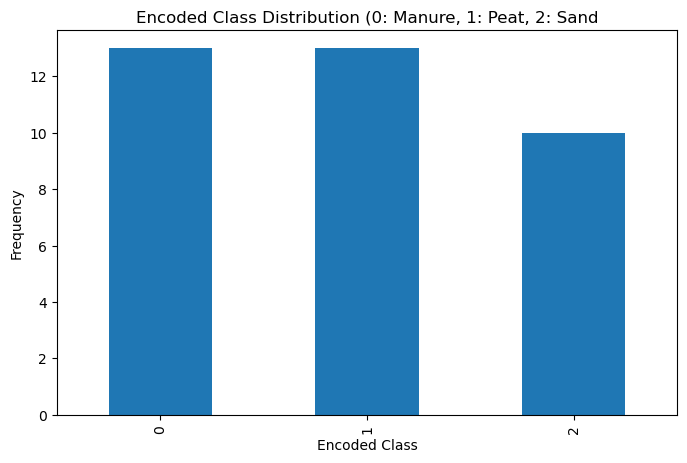

Genus  Georgfuchsia  Alcanivorax  UBA6140  Tahibacter  Flavimaricola  BIyi10  \
1               449            0     1725         464             58    1585   
2               174           93     4791         562             80     788   
3               396            4     1677         311            137    1465   
4               379           33     1987         210             26    1444   
5               277           63     3926         565            103    1467   

Genus  Rhodovastum  Agrobacterium  Anaerolinea  Sphaerobacter  ...  \
1               90            142          740             62  ...   
2              182             88          173             44  ...   
3              312            157          401             89  ...   
4               86            210          475             33  ...   
5              313            132          351             54  ...   

Genus  Rubrivirga  Pedomicrobium  Micropepsis  Methyloversatilis  \
1               0           25

In [66]:
# Load and transpose the main data
# Aviti_raw_data
# X = pd.read_csv('Aviti_raw_data.txt', delimiter='\t', index_col=0).T
# Miseq_raw_data
# X = pd.read_csv('Miseq_raw_data.txt', delimiter='\t', index_col=0).T
# Novaseq_raw_data
X = pd.read_csv('Novaseq_raw_data.txt', delimiter='\t', index_col=0).T

print(X.head())

X.index = X.index.astype(str)

# Load metadata
metadata = pd.read_excel('Metadata.xlsx')

# Extract digits after the first 3 characters
metadata['Sample_num'] = metadata['Sample_name'].astype(str).str.slice(3).str.extract(r'(\d+)')[0]

# Create a mapping from numeric sample name → soil type
sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Soil']))
# Create a mapping from numeric sample name → Autoclave type
# sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Autoclave']))
# Create a mapping from numeric sample name → Heat root type
# sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Heat root']))

# Map sample names in X to soil types
y_raw = X.index.map(sample_to_condition)

# Keep only samples with valid labels
valid_samples = y_raw.notna()
X = X[valid_samples]
y_raw = y_raw[valid_samples]
feature_names = X.columns.tolist()
# Encode soil types
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Create a DataFrame showing sample names and their labels ---> for debugging purpose
labels_df = pd.DataFrame({
    'Sample_Name': X.index,
    'Soil_Type': y_raw.values,
    'Soil_Label': y
})

# Display the result
print("🧾 Sample names with their respective labels:")
print(labels_df)



print("Encoded Class Distribution:")
print(pd.Series(y).value_counts())
# Plot the class distribution
plt.figure(figsize=(8, 5))
pd.Series(y).value_counts().plot(kind='bar')
# when condition = soil
plt.title('Encoded Class Distribution (0: Manure, 1: Peat, 2: Sand')
#  when condition = autoclave or Heat root
# plt.title('Encoded Class Distribution (0: No, 1: Yes)')
plt.xlabel('Encoded Class')
plt.ylabel('Frequency')
plt.show()

# Check for missing values --> none
# print(f"Columns with missing values: {data.columns[data.isnull().any()].tolist()}")
# # Feature selection ------------------>??
# rf = RandomForestClassifier(n_estimators=15, random_state=42)
# rf.fit(X, y)
# feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
# # Count the number of features with 0.0 importance and print their names -----> only 46 is important out of 1017 when label is soil
# zero_importance_features = feature_importances[feature_importances == 0.0].index.tolist()
# print(f"\nNumber of features with 0.0 importance: {len(zero_importance_features)}")
# print("Features with 0.0 importance:", zero_importance_features)
# print("\nFeature Importances:")
# print(feature_importances.sort_values(ascending=False))
# # Remove zero importance features from X
# X_reduced = X.drop(columns=zero_importance_features) 
# feature_names_reduced = X_reduced.columns.tolist()
# print("\nX_reduced.shape is ", X_reduced.shape)
# print("\nX_reduced names.shape is ", len(feature_names_reduced))
# print(feature_names_reduced

#### Using SHAP Features instad of All features
## SHAP, Aviti soil 🍳
# # desired_columns=[
#  'Acidovorax', 'Actinoplanes','Arenibacter', 'Azotobacter',
#  'BIyi10', 'Confluentibacter', 'Croceicoccus', 'Crocinitomix',
#  'Denitratisoma', 'Ferrovibrio', 'Flavobacterium', 'Gemmobacter',
#  'Ideonella', 'Ignavibacterium', 'Ilumatobacter', 'JTB255 marine benthic group',
#  'Kribbella', 'Leptothrix', 'Phreatobacter', 'Planktosalinus',
#  'Pusillibacter', 'Roseomonas', 'Ruminofilibacter', 'Rurimicrobium',
#  'Shinella', 'Sphingosinicella', 'Thermobispora'
# ]
## SHAP, Aviti Autoclave 🍕
# desired_columns=[ 'Ammoniphilus','Neobacillus','Inquilinus','Crocinitomix','Asticcacaulis','Opitutus',
#                  'Reyranella','FFCH7168','Spirochaeta 2','Achromobacter', 'Prosthecobacter','YC-ZSS-LKJ147',
#                  'Rhodoplanes', 'UTCFX1','Cephaloticoccus','Pseudoxanthobacter','Aquisphaera','Duganella','Microvirga','Bauldia']
## SHAP, Aviti Heat Root
# desired_columns=['Mesorhizobium','Mycobacterium','Taibaiella','Candidatus Nitrosoarchaeum',
# 'Cavicella','Nocardioides','Candidatus Ovatusbacter','Yinghuangia','Aggregatilinea','Sandaracinus','Caenimonas',
# 'JGI 0001001-H03','LD29','Oligoflexus','Marinoscillum','Bradyrhizobium','Archangium','Constrictibacter','Subgroup 10','Aquihabitans']

# ## SHAP, Miseq soil🍳
# desired_columns= [
#     'UBA6140','BIyi10','Candidatus Dichloromethanomonas','Opitutus', 'Gemmata','Dokdonella', 'Croceicoccus',
#     'Ilumatobacter',   'Methylobacter','Planctomicrobium',    'Bryobacter','Fuscovulum',  'SWB02','MND1', 
#     'Luteitalea','Oleiharenicola','Methylobacillus','Paludibaculum','Dongia','Bradyrhizobium', 'Permianibacter',
#     'Agrobacterium','Nitrosospira','Steroidobacter','Panacibacter','Acidibacter','Candidatus Berkiella', 'Lacibacter',
#     'Aurantisolimonas','Emticicia','Sphingorhabdus', 'Azospirillum','OLB12','Ideonella','Ferribacterium', 'Shinella'
# ]

# ## SHAP, Miseq autoclave 🍕
# desired_columns=['Methylobacillus','Devosia','Bauldia','Steroidobacter','Acidibacter',
# 'Ramlibacter','Crocinitomix','Rhodoplanes','Phaeodactylibacter','Chthoniobacter','CL500-29 marine group',
# 'Imperialibacter','Luteolibacter','Arsenicitalea','mle1-7','Croceibacterium','Phenylobacterium','Cypionkella',
# 'Aridibacter','Hirschia']

# ## SHAP, Miseq HeatRoot
# desired_columns=['Rhodoplanes','Nemorincola','Marinoscillum','Phaeodactylibacter','Hyphomicrobium',
# 'Algoriphagus','Acidovorax','Hassallia','Pedomicrobium','OLB13','Phenylobacterium',
# 'Spirochaeta 2','Lysinibacillus','DSSD61','Fuscovulum','Pelotalea','Croceibacterium',
# 'Brevundimonas','Ohtaekwangia','Niallia']


## SHAP, Novaseq soil 🍳
desired_columns = [
    'Georgfuchsia',
    'Alcanivorax',
    'UBA6140',
    'Tahibacter',
    'Flavimaricola',
    'BIyi10',
    'Rhodovastum',
    'Agrobacterium',
    'Anaerolinea',
    'Sphaerobacter',
    'Rhodovarius',
    'Variovorax',
    'Thiobacillus',
    'Permianibacter',
    'Hirschia',
    'DEV008',
    'Rhodoligotrophos',
    'Leptospirillum',
    'Syntrophus',
    'Rubrivirga',
    'Pedomicrobium',
    'Micropepsis',
    'Methyloversatilis',
    'Planctomicrobium',
    'Opitutus',
    'Desulfocastanea',
    'Sulfuricurvum',
    'UBA12409',
    'Muricauda'
]



# desired_columns = list(set(desired_columns))

# # ## SHAP, Novaseq autoclave 🍕
# desired_columns=['Achromobacter','Devosia','Ammoniphilus','Phaeodactylibacter','CSP1-2','Brevibacillus','Sulfuricaulis'
# ,'Niallia','Pseudoxanthobacter','Stenotrophobacter','I-8','Thermopolyspora','Faecalibacterium','Paenibacillus','Abditibacterium',
# 'Massilia','Haloplasma','Ilumatobacter','Panacagrimonas','Urania-1B-19 marine sediment group']

# ## SHAP, Novaseq HeatRoot
# desired_columns=['Abditibacterium','Noviherbaspirillum','Nocardia','Arcticibacter','Galbitalea','Methylotenera','Mariniblastus',
# 'Lentzea','Aneurinibacillus','C1-B045','Azovibrio',
# 'possible genus 04','Povalibacter',
# 'Paludibacterium','Pedobacter','Immundisolibacter','Thauera','Nemorincola','Pedosphaera','Knoellia']


# uncomment the following line if you choose SHAP features in "desired_columns" and not al features ones.
X = X[desired_columns]
print(X.head())

In [67]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Show the shapes of the splits
print("📊 Train set shape:", X_train.shape)
print("📊 Test set shape:", X_test.shape)


# #Scale the feature/columns values
# scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(X_reduced)
# X_train = scaler.fit_transform(X_train)
# X_train.shape
# X_test = scaler.fit_transform(X_test)
# X_test.shape

📊 Train set shape: (27, 29)
📊 Test set shape: (9, 29)


C:\Users\hassa\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}

Cross-Validation Scores from GridSearchCV:
      mean_test_score  std_test_score  \
0           1.000000        0.000000   
1           1.000000        0.000000   
2           1.000000        0.000000   
3           1.000000        0.000000   
4           1.000000        0.000000   
..               ...             ...   
283         1.000000        0.000000   
284         0.966667        0.066667   
285         1.000000        0.000000   
286         1.000000        0.000000   
287         1.000000        0.000000   

                                                params  
0    {'max_depth': None, 'max_features': 'sqrt', 'm...  
1    {'max_depth': None, 'max_features': 'sqrt', 'm...  
2    {'max_depth': None, 'max_features': 'sqrt', 'm...  
3    {'max_depth': None, 'max_features': 'sqrt', 'm...  
4    {'max_depth': None, 'max_features': 's

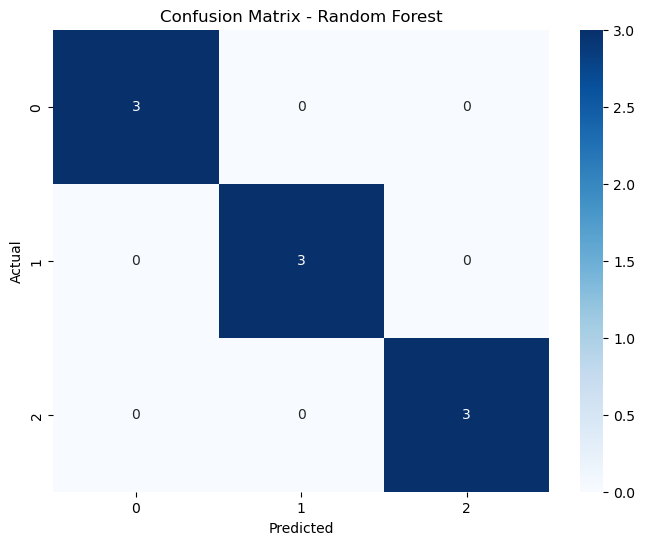

In [68]:
### Random Forest Classifier ###
# Hyperparameter Tuning and Cross-Validation for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
# Set a random_state for reproducibility
random_state = 42
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest:", best_params_rf)

# Print Cross-Validation Scores from GridSearchCV
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
print("\nCross-Validation Scores from GridSearchCV:\n", cv_results_rf[['mean_test_score', 'std_test_score', 'params']])

# Initialize the best Random Forest model
rf_model = RandomForestClassifier(**best_params_rf,random_state=random_state)

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation for Random Forest
print("\nRandom Forest - Test Set Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_rf))

# make sure the labels match
print("Unique values in y_test:", np.unique(y_test))

# Confusion Matrix
class_labels = rf_model.classes_
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SHAP Analysis, on train set. Use the following codes only for "Autoclave" and "Heat root" that have binary values
# Use TreeExplainer for Random Forest
# explainer_rf = shap.TreeExplainer(rf_model)

# # Calculate SHAP values
# shap_values_rf = explainer_rf.shap_values(X_train)
# print("Random Forest shap_values shape is", np.shape(shap_values_rf))

# # Select the SHAP values for the positive class (class 1/yes)
# shap_values_rf_selected = shap_values_rf[:, :, 1]
# # Print the shape of the resulting array
# print("Selected SHAP values shape:", shap_values_rf_selected.shape)

# # Create an Explanation object
# shap_values_rf_explanation = shap.Explanation(
#     shap_values_rf_selected,
#     base_values=explainer_rf.expected_value[1],  # Use the expected value of the positive class
#     data=X_train,
#     feature_names=feature_names
#     # feature_names=feature_names_reduced
# )

# # Generate SHAP plots for the Train set
# # Summary Plot
# shap.summary_plot(shap_values_rf_explanation, X_train, feature_names=feature_names)
# # shap.summary_plot(shap_values_rf_explanation, X_train, feature_names=feature_names_reduced)
# # Bar Plot
# shap.plots.bar(shap_values_rf_explanation)

# # Beeswarm Plot
# shap.plots.beeswarm(shap_values_rf_explanation)

# # # Waterfall Plot for the first instance
# # shap.plots.waterfall(shap_values_rf_explanation[0])

# print("Model classes:", rf_model.classes_)

#### Use the following cell when "Soil" is the intended label, which has 3 values

Random Forest shap_values shape is (27, 1316, 3)
[[ 693    0   13 ...  144  816    0]
 [ 616   42  473 ...  184   94    0]
 [ 375    0   22 ...   30  857    0]
 ...
 [2115    0  161 ...   34  113    0]
 [1467    0   19 ...   17  272    0]
 [1985    0  105 ...   32  293    0]]
SHAP values shape: (27, 1316, 3)
Generating SHAP plots for Class: Manure


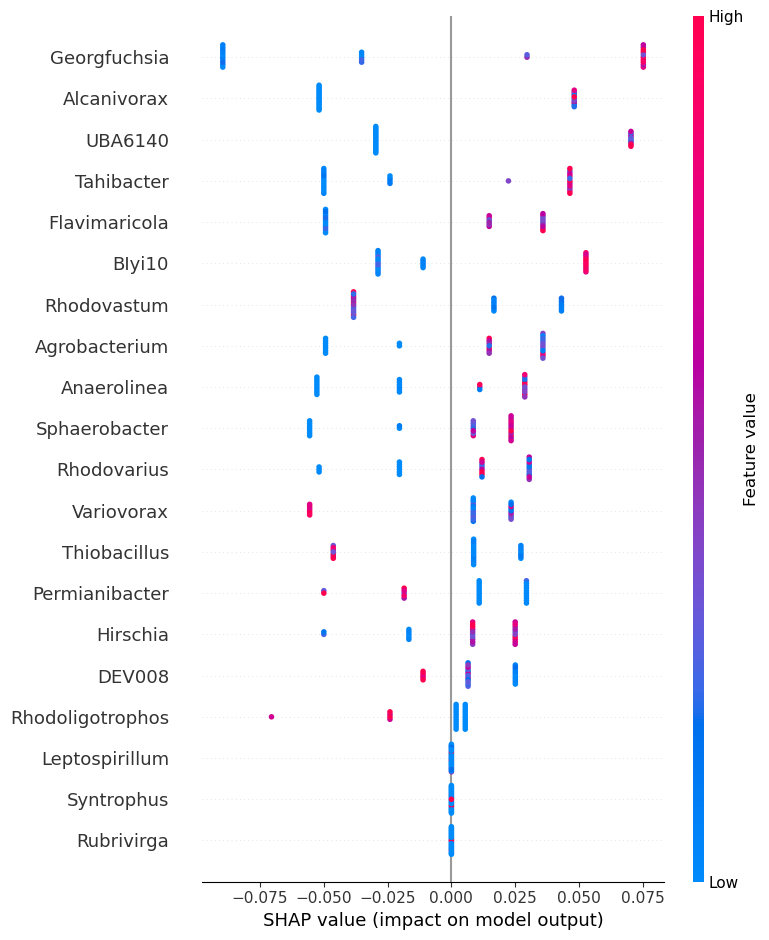

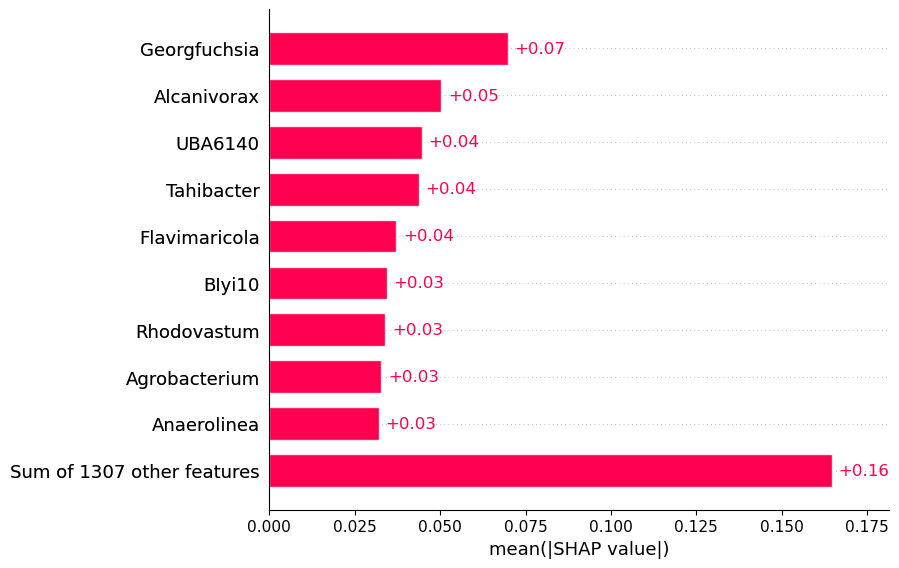

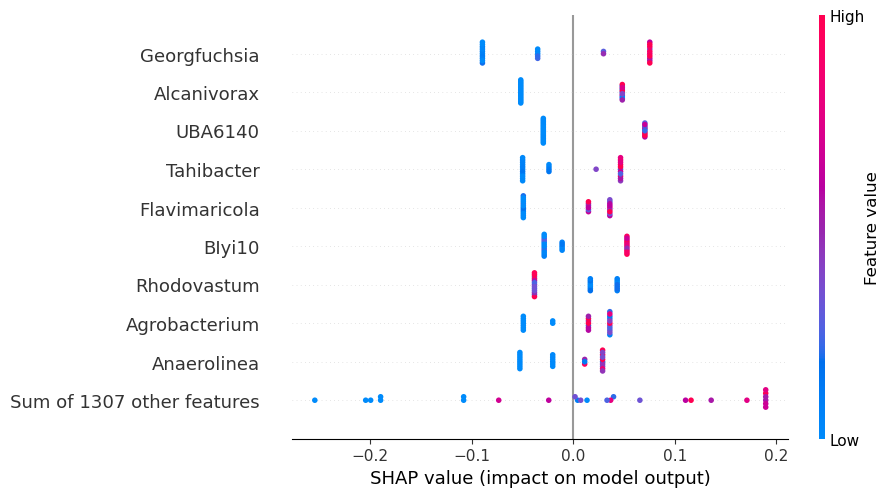

Generating SHAP plots for Class: Peat


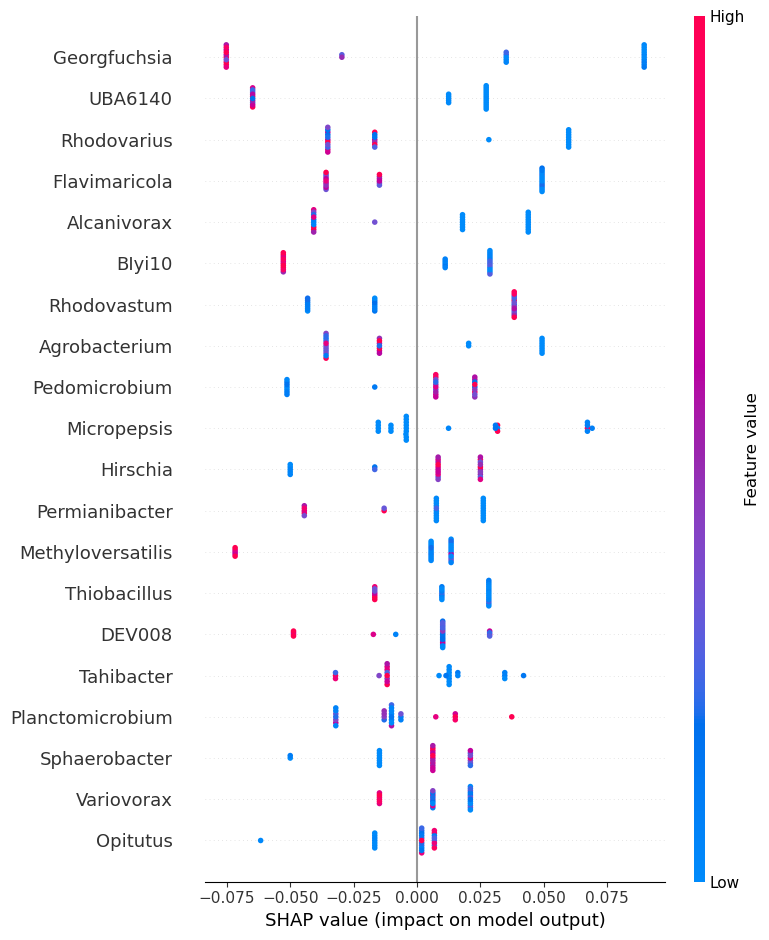

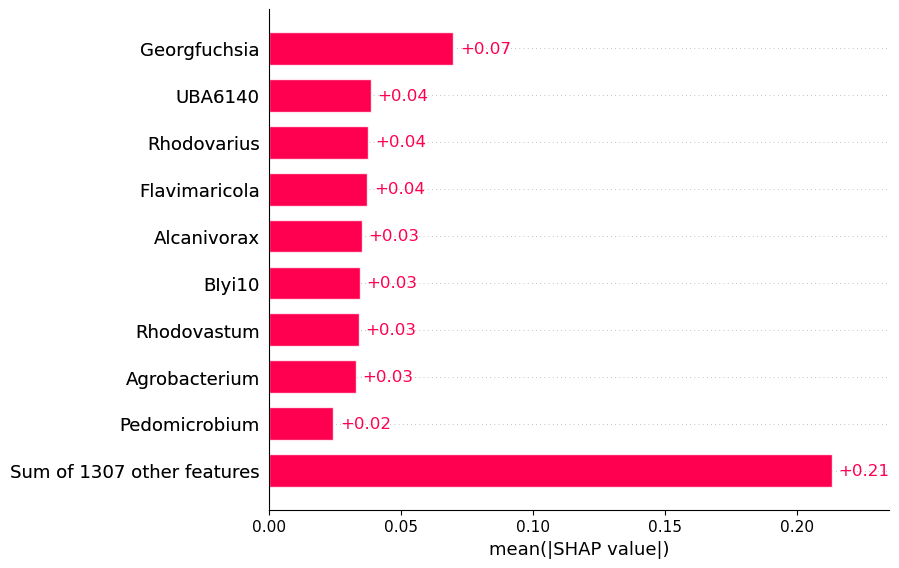

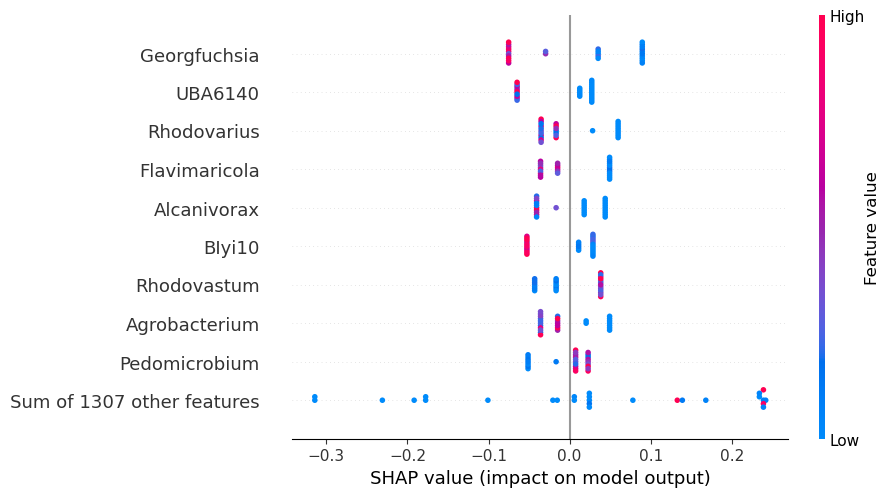

Generating SHAP plots for Class: Sand


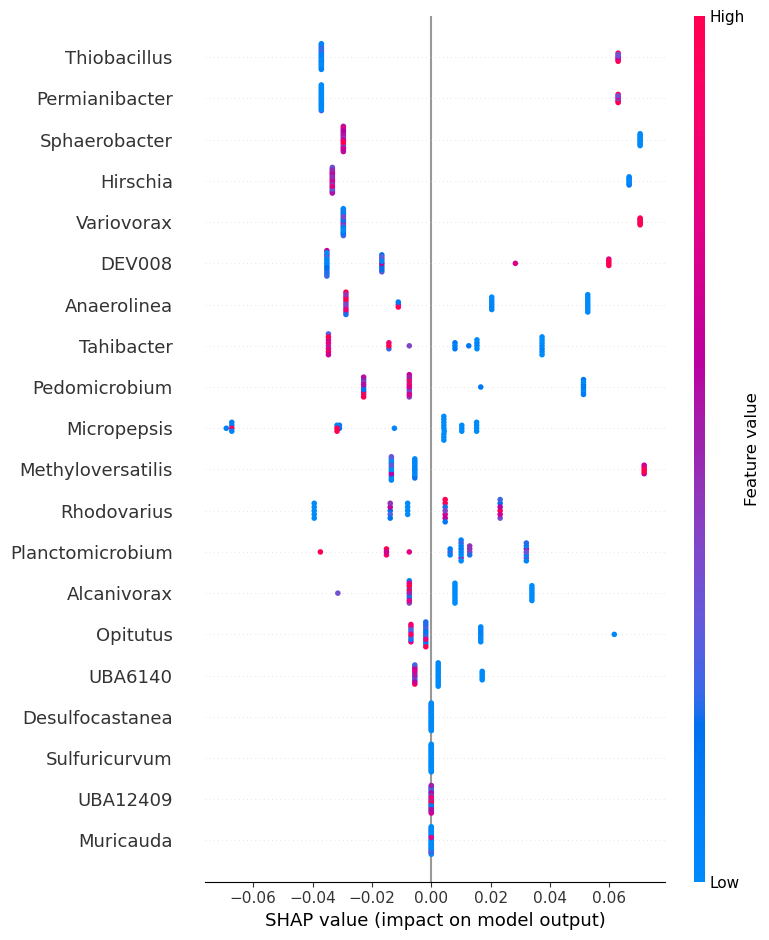

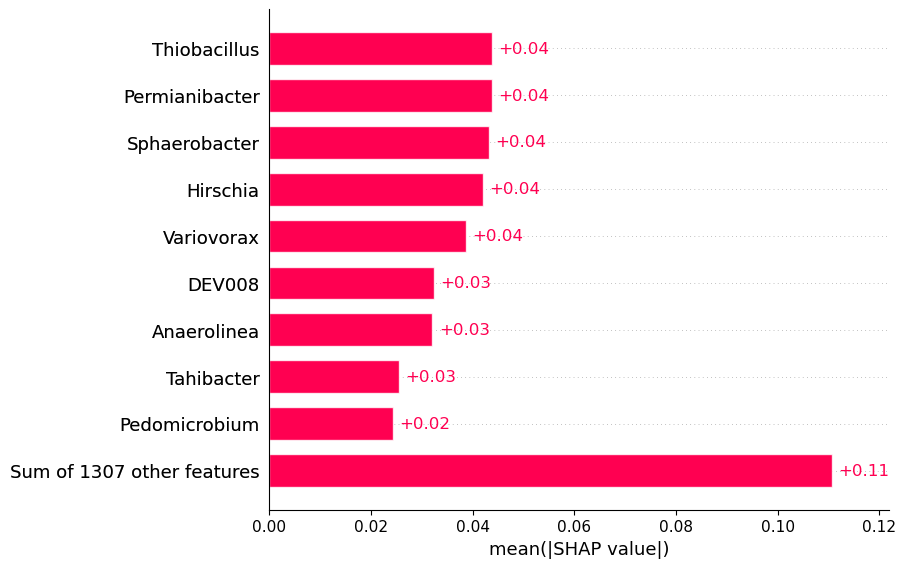

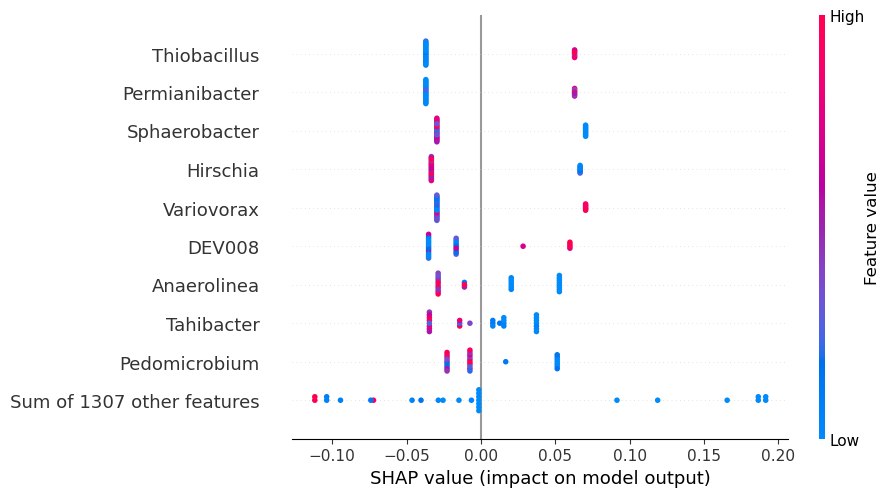

In [38]:
# Use TreeExplainer for Random Forest, on the train set
explainer_rf = shap.TreeExplainer(rf_model)
# Calculate SHAP values
# shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_rf = explainer_rf.shap_values(X_train)
print("Random Forest shap_values shape is", np.shape(shap_values_rf))  # Should output (number_of_classes, number_of_samples, number_of_features)

# Ensure X_test is an array
# X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
X_train_array = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
print(X_train_array)
# Check the shape of shap_values_rf
print("SHAP values shape:", shap_values_rf.shape)

# Generate all SHAP plots for each class
for i in range(shap_values_rf.shape[2]):
    print(f"Generating SHAP plots for Class: {le.classes_[i]}")

    # Ensure the shapes match for the summary plot
    class_shap_values = shap_values_rf[:, :, i]
    
    # Create an Explanation object for the current class
    shap_explanation = shap.Explanation(
        values=class_shap_values,  # SHAP values for class i
        base_values=explainer_rf.expected_value[i],  # Base values for class i
        # data=X_test_array,
        data=X_train_array,
        # feature_names=feature_names_reduced
        feature_names=feature_names
    )

    # Summary Plot
    shap.summary_plot(shap_explanation,X_train_array, feature_names=feature_names, class_names=le.classes_)
    # shap.summary_plot(shap_explanation,X_test_array, feature_names=feature_names, class_names=le.classes_)
    # shap.summary_plot(shap_explanation, X_test_array, feature_names=feature_names_reduced, class_names=le.classes_)

    # Bar Plot
    shap.plots.bar(shap_explanation, max_display=10)

    # Beeswarm Plot
    shap.plots.beeswarm(shap_explanation)

    # # Waterfall Plot for the first instance
    # shap.plots.waterfall(shap_explanation[0])

